# PyVista for OpenFOAM

Manipulation and visualization of OpenFOAM results using PyVista: see [here](https://docs.pyvista.org/examples/99-advanced/openfoam_example.html) for more details.

We will analyse a flow over cylinder problem solved with OpenFOAM-com (v2012). Remember to unzip the `flowcyl.zip` file in the same directory as this notebook.

Read the OpenFOAM case from a `.foam` file

In [2]:
import pyvista as pv

reader = pv.POpenFOAMReader('flowcyl/foam.foam')

The case contains an `UnstructuredGrid` element containing the fields `U`, `p`. The default time step is `0`, but you can change it to any other time step available in the case.

In [3]:
reader.read()

MultiBlock (0x10c8890c0)
  N Blocks:   2
  X Bounds:   -6.075e-01, 1.120e+00
  Y Bounds:   -6.000e-01, 6.000e-01
  Z Bounds:   -7.500e-03, 7.500e-03

The time instants saved can be printed

In [4]:
times = reader.time_values

## Contour plotting
In `internalMesh`, the fields are saved as point data or cell data, which can be used for plotting.

In [5]:
reader.set_active_time_value(reader.time_values[-1])
mesh = reader.read()['internalMesh']
mesh

UnstructuredGrid (0x10c343e20)
  N Cells:    34764
  N Points:   70396
  X Bounds:   -6.075e-01, 1.120e+00
  Y Bounds:   -6.000e-01, 6.000e-01
  Z Bounds:   -7.500e-03, 7.500e-03
  N Arrays:   4

Let us make a subplot: let us take a slice being this a 2D problem

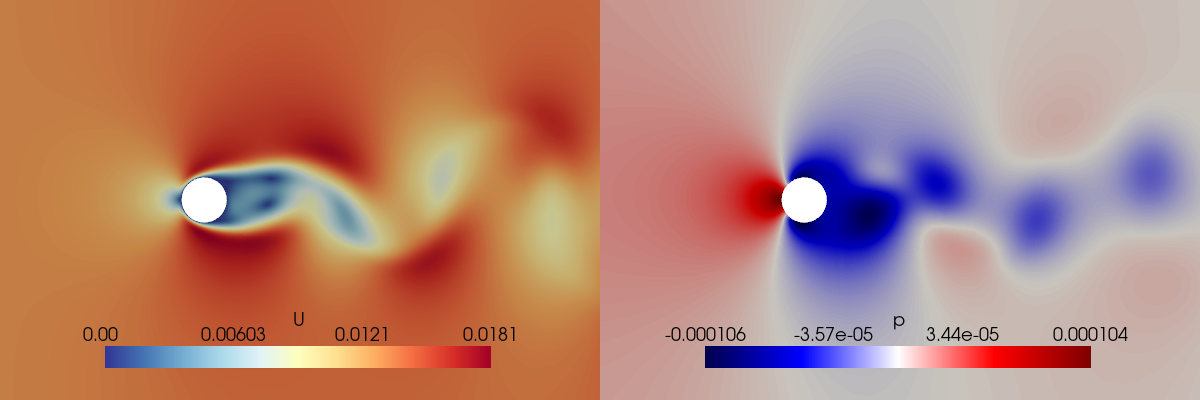

In [6]:
dict_cb = dict( width = 0.65, height = 0.15,
                    n_labels=4,
                    color = 'k',
                    position_x=0.175, position_y=0.0785,
                    shadow=False) 


pl = pv.Plotter(shape=(1, 2), border=False, window_size=(1200, 400))

pl.subplot(0,0)
pl.add_mesh(mesh.slice(normal='z'), scalars='U', cmap='RdYlBu_r', scalar_bar_args=dict_cb)

pl.subplot(0,1)
pl.add_mesh(mesh.slice(normal='z'), scalars='p', cmap='seismic', scalar_bar_args=dict_cb)

for i in range(2):
    pl.subplot(0, i)
    pl.view_xy()
    pl.camera.zoom(2)

pl.show(jupyter_backend='static')

Let us make a gif/plot of the velocity magnitude over time

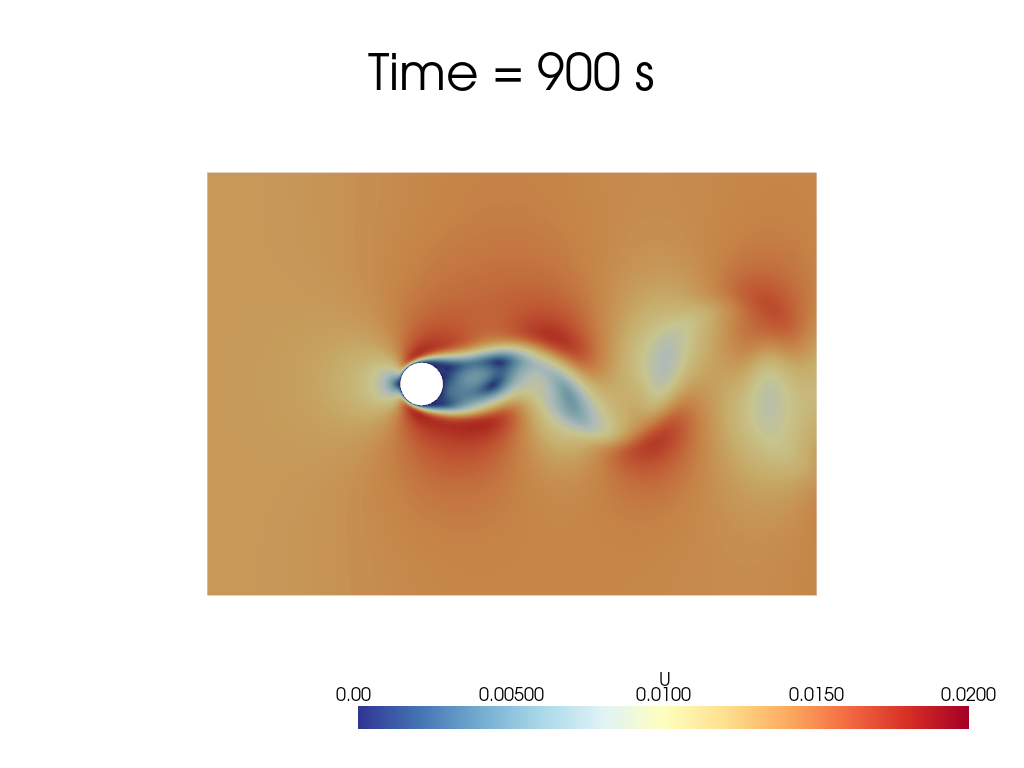

In [42]:
from IPython.display import clear_output as clc

pl = pv.Plotter()

for idx in range(len(times)):
    reader.set_active_time_value(reader.time_values[idx])
    mesh = reader.read()['internalMesh'].slice(normal='z')
    mesh.set_active_scalars('U')
    pl.add_mesh(mesh, scalars='U', cmap='RdYlBu_r', show_edges=False, clim=[0, 0.02])
    pl.view_xy()

    pl.add_title(f'Time = {times[idx]:.0f} s', font_size=20)

    pl.set_background('white')
    pl.show(jupyter_backend='static', auto_close=True)
    clc(wait=True)

    mesh.clear_data()

pl.screenshot('flowcyl_U_slices.png')
pl.close()

Let us make a subplot with a single colorbar (row collapsed)

`Note: not able to rotate properly the title of the colorbar`

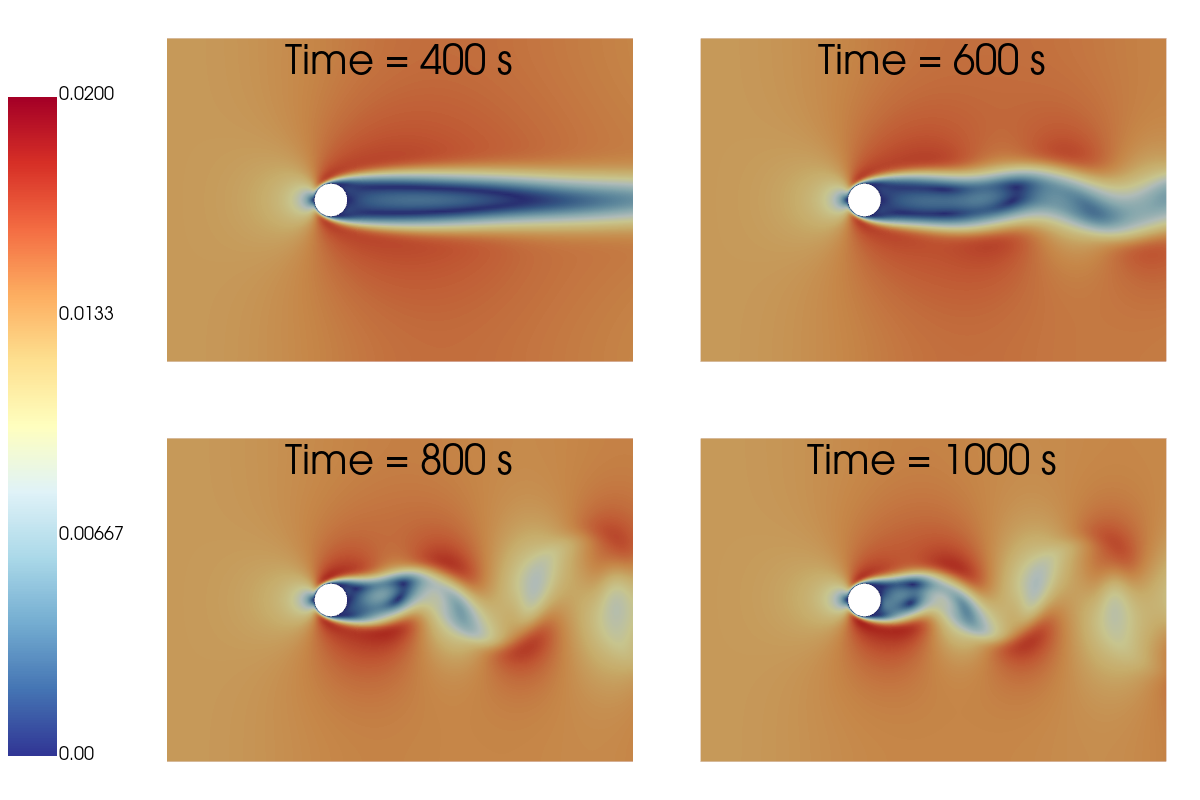

In [52]:
import numpy as np
dict_cb = dict( width = 1, height = 0.85,
               title=' ',
                    n_labels=4,
                    color = 'k',
                    vertical = True,
                    position_x=0.05, position_y=.05,
                    shadow=False) 

shape = (2, 3)
row_weights = [1, 1]
col_weights = [0.25, 1, 1]
groups = [
    (np.s_[:], 0), 
]

pl = pv.Plotter(shape=shape, row_weights=row_weights, col_weights=col_weights, border=False, 
                groups=groups,
                window_size=(1200, 800)
                )

i = 2
for row in range(2):
    for col in range(2):
        pl.subplot(row, col+1)
        t_idx = i * 2

        reader.set_active_time_value(reader.time_values[t_idx])
        mesh = reader.read()['internalMesh'].slice(normal='z')
        mesh.set_active_scalars('U')

        pl.add_mesh(mesh, cmap='RdYlBu_r', scalars='U', show_edges=False, clim=[0, 0.02],
        # scalar_bar_args=dict_cb,
        show_scalar_bar=False
        )
        pl.add_title(f'Time = {times[t_idx]:.0f} s', font_size=16)
        pl.view_xy()
        pl.camera.zoom(1.45)
        pl.set_background('white')
        i += 1

pl.subplot(0, 0)
scalar_bar = pl.add_scalar_bar(**dict_cb)
pl.show(jupyter_backend='static')

Let us make a subplot with a single colorbar (col collapsed)

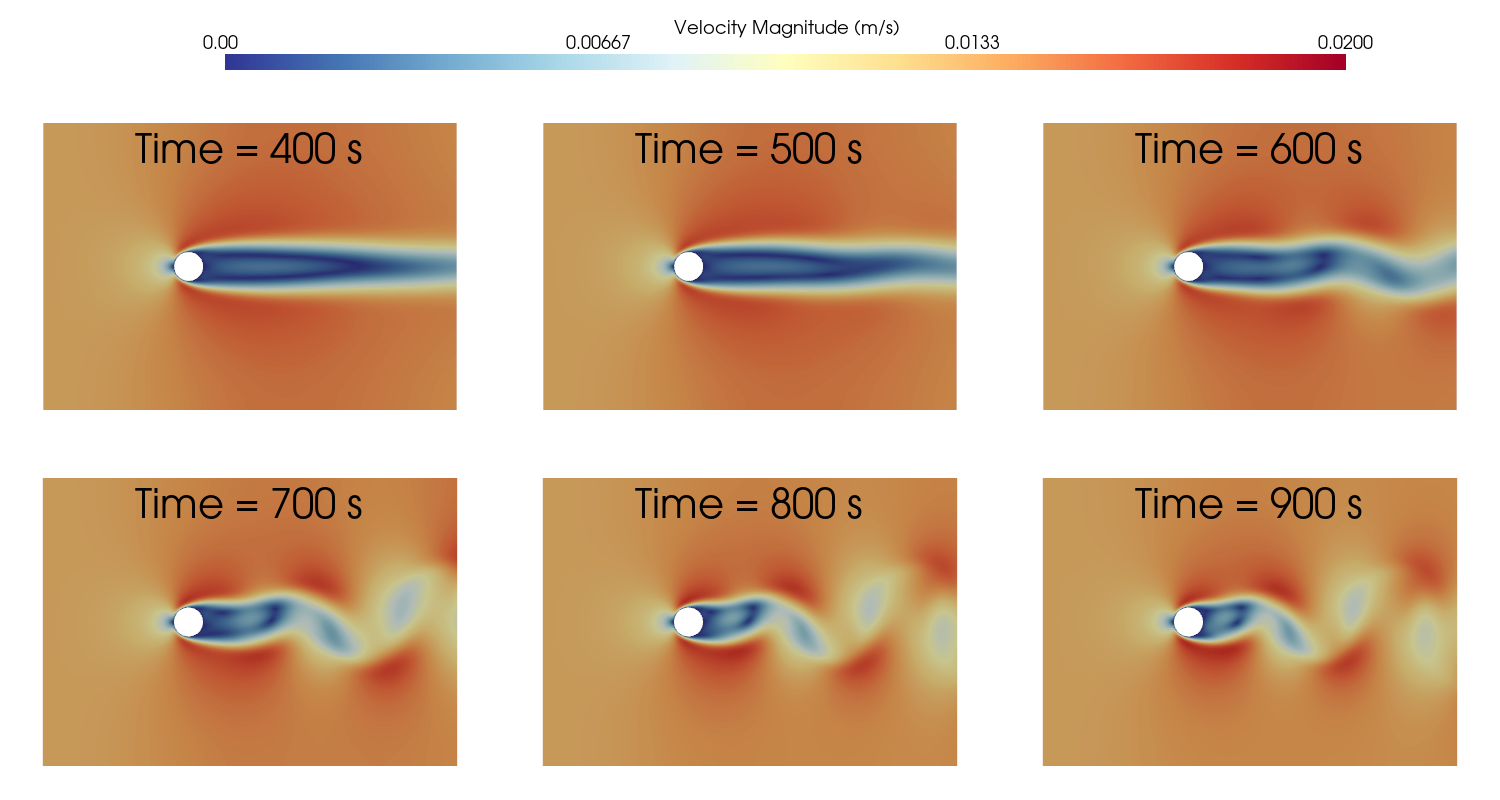

In [57]:
import numpy as np
dict_cb = dict( width = 0.75, height = 0.5,
               title='Velocity Magnitude (m/s)',
                    n_labels=4,
                    color = 'k',
                    vertical = False,
                    position_x=0.15, position_y=.2,
                    shadow=False) 

shape = (3, 3)
row_weights = [0.25, 1, 1]
col_weights = [1, 1, 1]
groups = [
    (1,0),
    (0, np.s_[:]), 
]

pl = pv.Plotter(shape=shape, row_weights=row_weights, col_weights=col_weights, border=False, 
                groups=groups,
                window_size=(1500, 800)
                )

i = 4
for row in range(len(row_weights)-1):
    for col in range(len(col_weights)):
        pl.subplot(row+1, col)
        t_idx = i * 1

        reader.set_active_time_value(reader.time_values[t_idx])
        mesh = reader.read()['internalMesh'].slice(normal='z')
        mesh.set_active_scalars('U')

        pl.add_mesh(mesh, cmap='RdYlBu_r', scalars='U', show_edges=False, clim=[0, 0.02],
        # scalar_bar_args=dict_cb,
        show_scalar_bar=False
        )
        pl.add_title(f'Time = {times[t_idx]:.0f} s', font_size=16)
        pl.view_xy()
        pl.camera.zoom(1.45)
        pl.set_background('white')
        i += 1

pl.subplot(0, 0)
scalar_bar = pl.add_scalar_bar(**dict_cb)
pl.show(jupyter_backend='static')

## Data Manipulation
We can also calculate the vorticity field $\boldsymbol{\omega} = \nabla \times \mathbf{u}$, which is a vector field, using the `vorticity` filter.

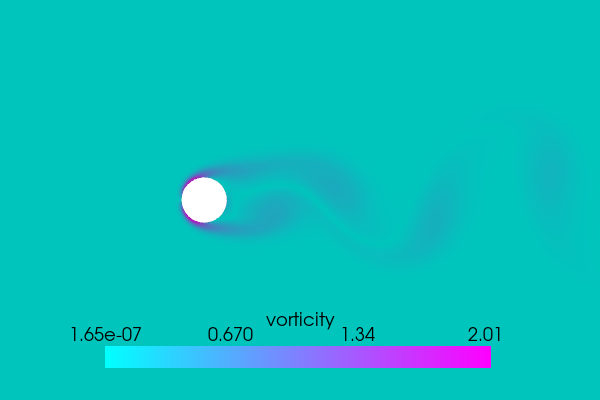

In [87]:
mesh['vorticity'] = mesh.compute_derivative(scalars='U', vorticity=True)['vorticity']

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.slice(normal='z'), scalars='vorticity', cmap='cool', scalar_bar_args=dict_cb)

pl.view_xy()
pl.camera.zoom(2)

pl.show(jupyter_backend='static')

Also, derivates like gradient and divergence can be calculated. For example, the gradient of the pressure field $p$ is a vector field $\nabla p$.

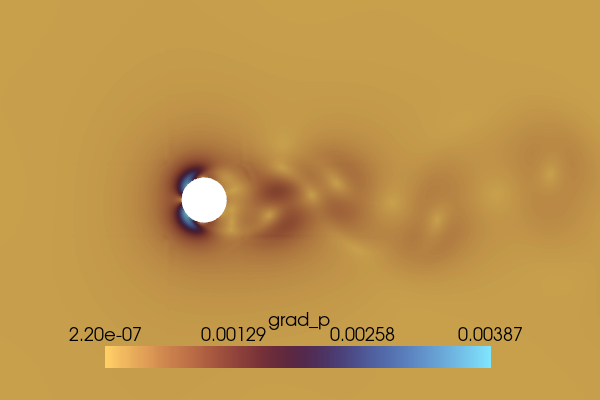

In [88]:
mesh['grad_p'] = mesh.compute_derivative(scalars='p', gradient=True)['gradient']

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.slice(normal='z'), scalars='grad_p', cmap='managua', scalar_bar_args=dict_cb)
pl.view_xy()
pl.camera.zoom(2)

pl.show(jupyter_backend='static')

Let us also calculate the divergence of the velocity field $\nabla \cdot \mathbf{u}$, which is a scalar field: since the flow is incompressible, this should be reasonably close to zero.

In [84]:
mesh.compute_derivative(scalars='U', divergence=True)['divergence'].mean()

6.4915384e-06

Let us calculate the Q-criterion. Starting from the tensor of the velocity field:

$$
S = \frac{1}{2}\left(\nabla \mathbf{u} + (\nabla \mathbf{u})^T\right)
\quad\text{e}\quad
\Omega = \frac{1}{2}\left(\nabla \mathbf{u} - (\nabla \mathbf{u})^T\right)
$$

the formulation of the Q-criterion is:

$$ 
Q = \frac{1}{2}\left(\|\Omega\|^2 - \|S\|^2\right)
$$

where $\|\cdot\|$ is the Frobenius norm.

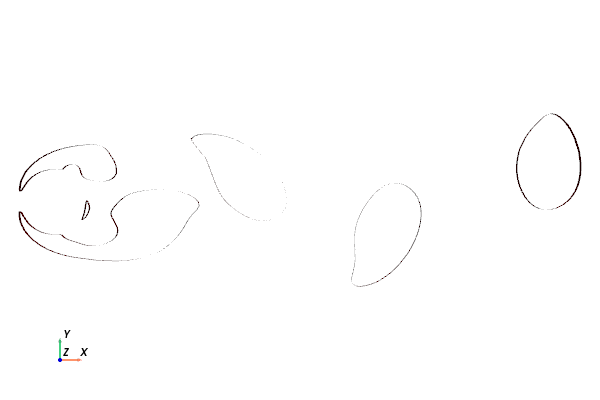

In [128]:
import numpy as np

mesh['criterion_q'] = mesh.compute_derivative(scalars='U', qcriterion=True)['qcriterion']

q_thres = np.percentile(mesh['criterion_q'], 95)

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.contour(isosurfaces=[q_thres], scalars='criterion_q'), scalars='criterion_q', cmap='jet_r', show_scalar_bar=False)
pl.add_axes()

pl.view_xy()
pl.camera.zoom(1.5)   

pl.show(jupyter_backend='static')

## Integral Calculations

`PyVista` can also calculate integrals over the mesh. For example, we can calculate the integral of the pressure field on the whole domain.

In [126]:
print('U:         ', mesh.integrate_data()['U'][0])
print('p:         ', mesh.integrate_data()['p'][0])
print('vorticity: ', mesh.integrate_data()['vorticity'][0])

U:          [ 4.03745810e-04 -1.07005666e-06  1.26237701e-24]
p:          7.345072318449489e-09
vorticity:  [ 1.63994584e-21  3.73016912e-21 -3.76893031e-05]
